In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

import missingno as mno
from sklearn import linear_model

import os
print(os.listdir("../input"))

['csvs_per_year', 'madrid.h5', 'stations.csv']


In [2]:
partials = list()
stations = list()

with pd.HDFStore('../input/madrid.h5') as data:
    stations = [k[1:] for k in data.keys() if k != '/master']
    for station in stations:
        df = data[station]
        df['station'] = station
        partials.append(df)

Opening ../input/madrid.h5 in read-only mode


In [3]:
measures = pd.concat(partials, sort=False).sort_index()
measures.head()

,CO,NO_2,NOx,O_3,PM10,PM25,SO_2,station,NO,BEN,EBE,MXY,NMHC,OXY,PXY,TCH,TOL,CH4
date,,,,,,,,,,,,,,,,,,
2001-01-01 01:00:00,1.23,55.750000,127.199997,8.38,44.950001,NaN,14.560000,28079017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-01-01 01:00:00,0.72,49.830002,74.040001,6.37,22.170000,NaN,28.290001,28079011,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-01-01 01:00:00,1.20,43.849998,71.440002,5.50,23.790001,NaN,41.520000,28079012,NaN,NaN,NaN,NaN,0.05,NaN,NaN,1.46,NaN,NaN
2001-01-01 01:00:00,0.74,49.410000,70.750000,2.49,36.820000,NaN,9.600000,28079039,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-01-01 01:00:00,0.45,67.120003,132.899994,7.86,32.349998,NaN,26.459999,28079008,NaN,4.09,2.38,NaN,NaN,NaN,NaN,NaN,11.7,NaN


In [4]:
measures.describe()

,CO,NO_2,NOx,O_3,PM10,PM25,SO_2,NO,BEN,EBE,MXY,NMHC,OXY,PXY,TCH,TOL,CH4
count,2.651012e+06,3.787050e+06,2.376275e+06,2.991732e+06,2.861255e+06,816424.000000,2.775960e+06,1.532397e+06,1.041684e+06,1.001724e+06,315415.000000,1.085312e+06,315695.000000,315584.000000,1.086441e+06,1.038929e+06,14850.000000
mean,5.503838e-01,5.047151e+01,1.093188e+02,3.982616e+01,2.893654e+01,13.738292,1.065539e+01,2.343886e+01,1.257431e+00,1.407927e+00,4.650394,1.873865e-01,2.280912,2.056178,1.435882e+00,5.876842e+00,1.300849
std,5.354483e-01,3.455288e+01,1.102871e+02,3.039249e+01,2.594859e+01,11.214146,9.121267e+00,5.021504e+01,1.910831e+00,2.146109e+00,5.599223,1.539529e-01,2.639609,2.395130,2.332228e-01,8.524460e+00,0.195550
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-31.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.020000
25%,2.600000e-01,2.400000e+01,4.000000e+01,1.271000e+01,1.150000e+01,6.450000,5.840000e+00,2.000000e+00,2.100000e-01,3.500000e-01,1.200000,9.000000e-02,0.960000,0.800000,1.300000e+00,1.100000e+00,1.170000
50%,4.000000e-01,4.400000e+01,7.615000e+01,3.486000e+01,2.149000e+01,11.000000,8.150000e+00,6.000000e+00,6.000000e-01,8.800000e-01,2.800000,1.500000e-01,1.320000,1.280000,1.380000e+00,3.160000e+00,1.250000
75%,6.500000e-01,6.958000e+01,1.397000e+02,5.999000e+01,3.775000e+01,17.670000,1.230000e+01,2.000000e+01,1.500000e+00,1.580000e+00,5.890000,2.400000e-01,2.740000,2.510000,1.510000e+00,6.990000e+00,1.400000
max,1.804000e+01,6.286000e+02,2.537000e+03,2.360000e+02,6.950000e+02,506.899994,1.991000e+02,1.146000e+03,6.639000e+01,1.622000e+02,177.600006,9.070000e+00,103.000000,106.000000,1.048000e+01,2.429000e+02,3.920000


In [5]:
measures.isnull().sum().apply(lambda x: (x / len(measures) * 100))

CO         30.387183
NO_2        0.556007
NOx        37.601491
O_3        21.440230
PM10       24.866421
PM25       78.561555
SO_2       27.106179
station     0.000000
NO         59.760849
BEN        72.646462
EBE        73.695770
MXY        91.717530
NMHC       71.500836
OXY        91.710178
PXY        91.713093
TCH        71.471190
TOL        72.718805
CH4        99.610054
dtype: float64

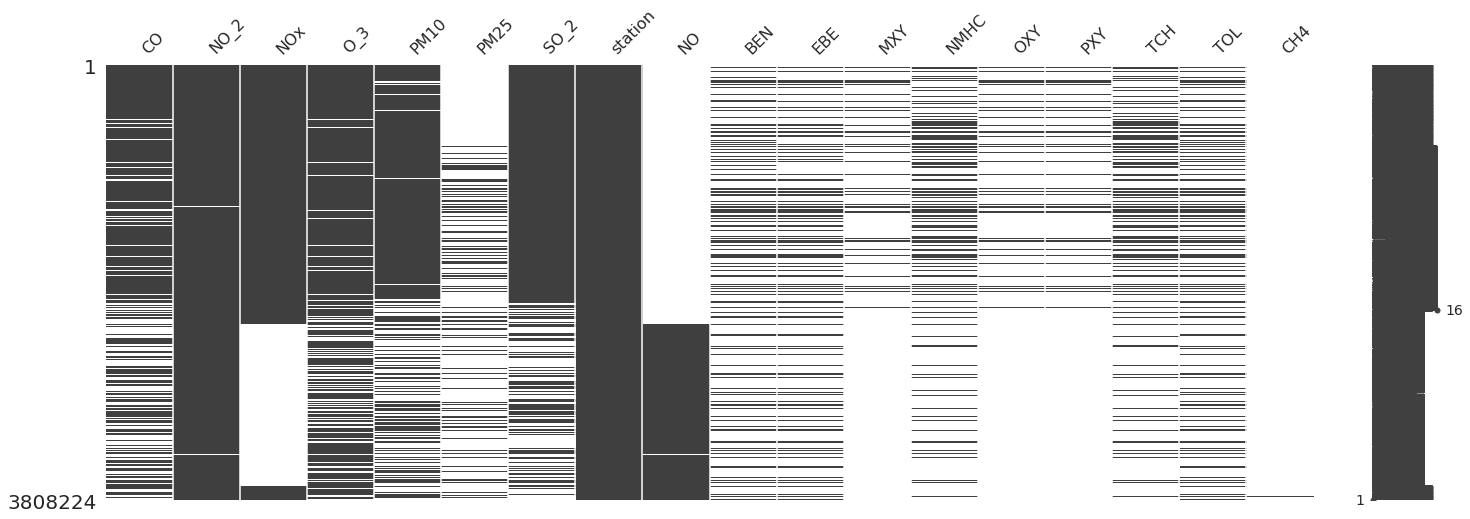

In [6]:
mno.matrix(measures, figsize = (24, 8))

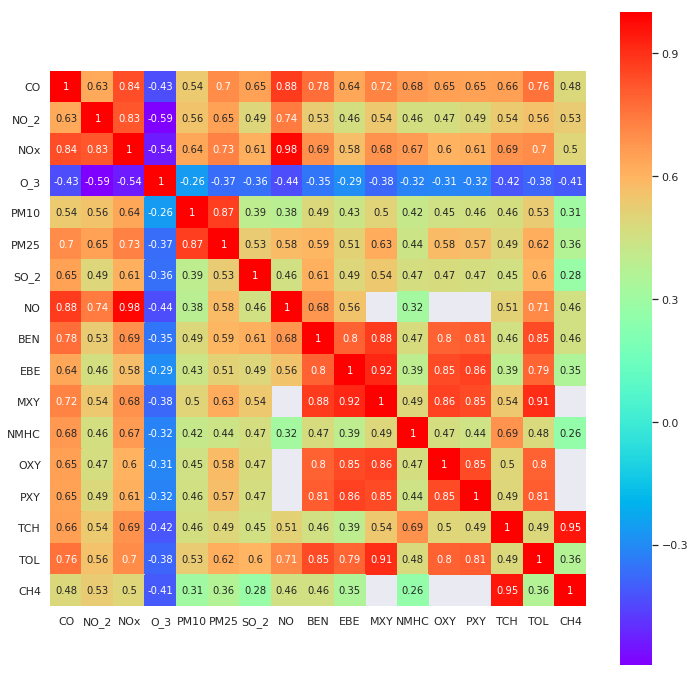

In [7]:
plt.figure(figsize=(12,12))
sns.heatmap(measures.drop('station', axis=1).corr(), square=True, annot=True, cmap='rainbow')

In [8]:
# get list of unique timestamps
RANDOM_STATION = '28079017'
one_station = measures[measures['station'] == RANDOM_STATION]
timestamps = one_station.index.to_series()

In [9]:
# only for EDA purposes to understand what we're dealing with
# for station in stations:
#     print("Station: {}".format(station))
#     total_observations = len(measures[measures['station'] == station])
#     print("Total observations per station: {}".format(total_observations))
#     print(measures[measures['station'] == station].notnull().sum().apply(lambda x: (x / total_observations * 100)))

In [10]:
column_to_check = 'NMHC'
list_of_dfs = list()
for station in stations:
    station_data = measures[measures['station'] == station]
    total_observations = len(station_data)
#     print("Total observations per station: {}".format(total_observations))
#     print(station_data[column_to_check].notnull().sum())
    if station_data[column_to_check].notnull().sum() > 0:
        list_of_dfs.append(station_data[['station',column_to_check]])

df_nmhc = pd.concat(list_of_dfs)

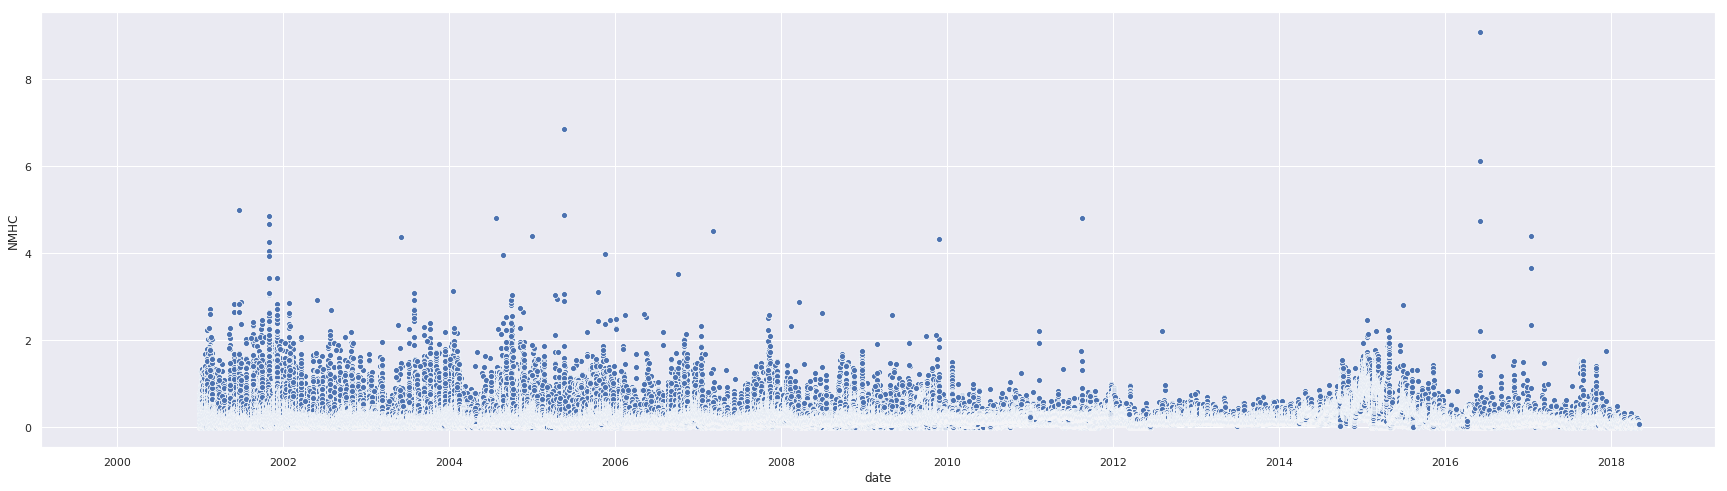

In [11]:
f = plt.figure(figsize=(30,8))
sns.scatterplot(x='date', y='NMHC', data=df_nmhc.reset_index())

We already see lots of suspicious records that might be outliers and distort the visualization. Let's check it with boxplot and violin plot to understand how really outliers influence the data.

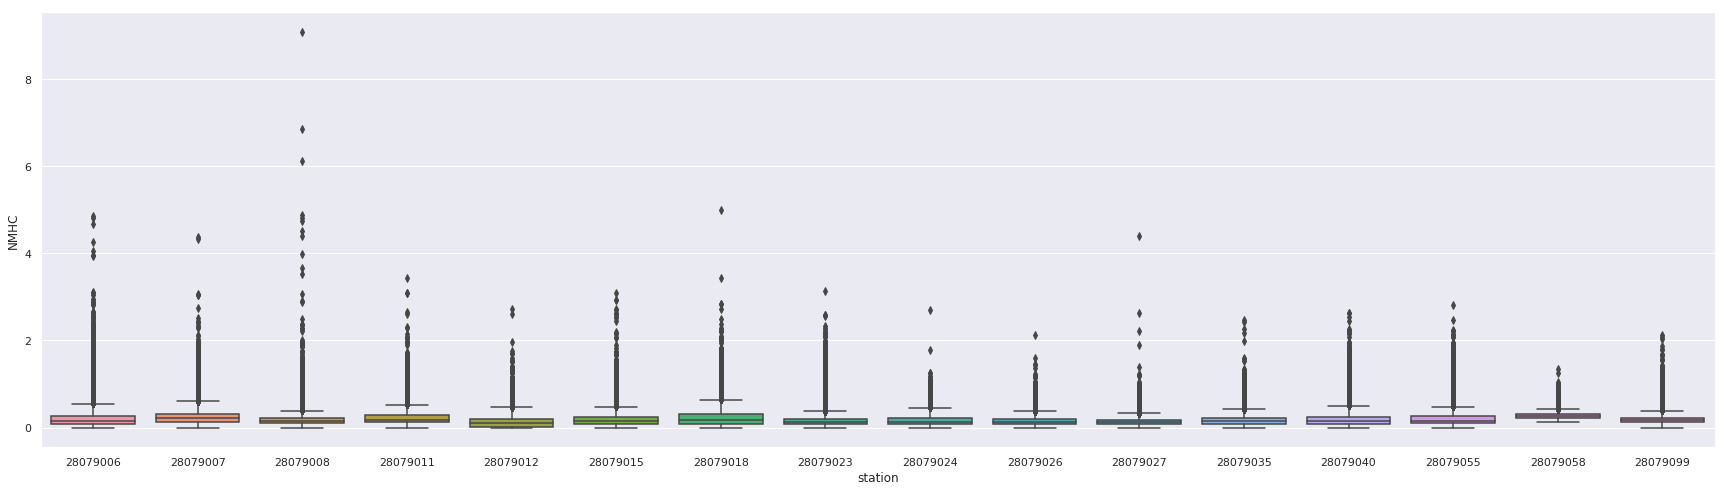

In [12]:
f = plt.figure(figsize=(30,8))
sns.boxplot(x='station', y='NMHC', data=df_nmhc.dropna(axis=0).reset_index())

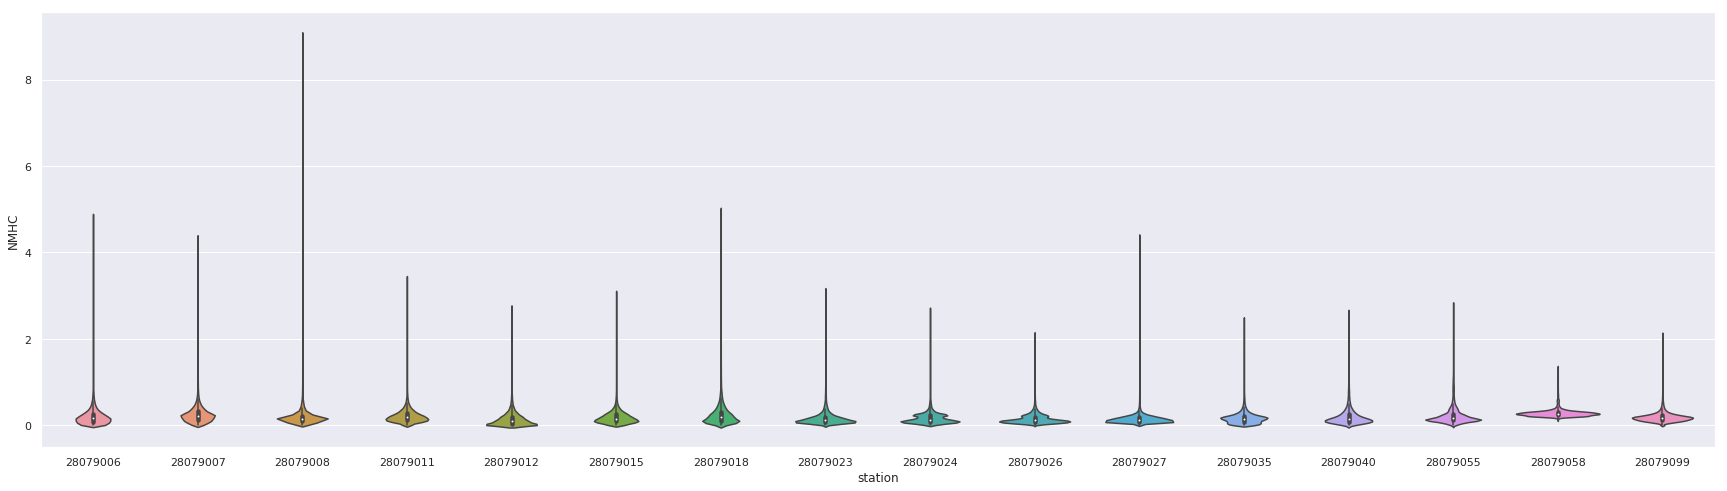

In [13]:
f = plt.figure(figsize=(30,8))
sns.violinplot(x='station', y='NMHC', data=df_nmhc.dropna(axis=0).reset_index())

And yes, we see a lot of outliers that can indicate particular events in the city that led to these measures that particular day/hour. Let's group our data into 8-hours sets and see how will it look.

In [14]:
df_nmhc_8h = df_nmhc.dropna(axis=0).groupby('station').resample('8H').mean().reset_index()
df_nmhc_8h.head()

,station,date,NMHC
0,28079006,2001-01-01 00:00:00,0.384286
1,28079006,2001-01-01 08:00:00,0.130000
2,28079006,2001-01-01 16:00:00,0.210000
3,28079006,2001-01-02 00:00:00,0.030000
4,28079006,2001-01-02 08:00:00,0.192500


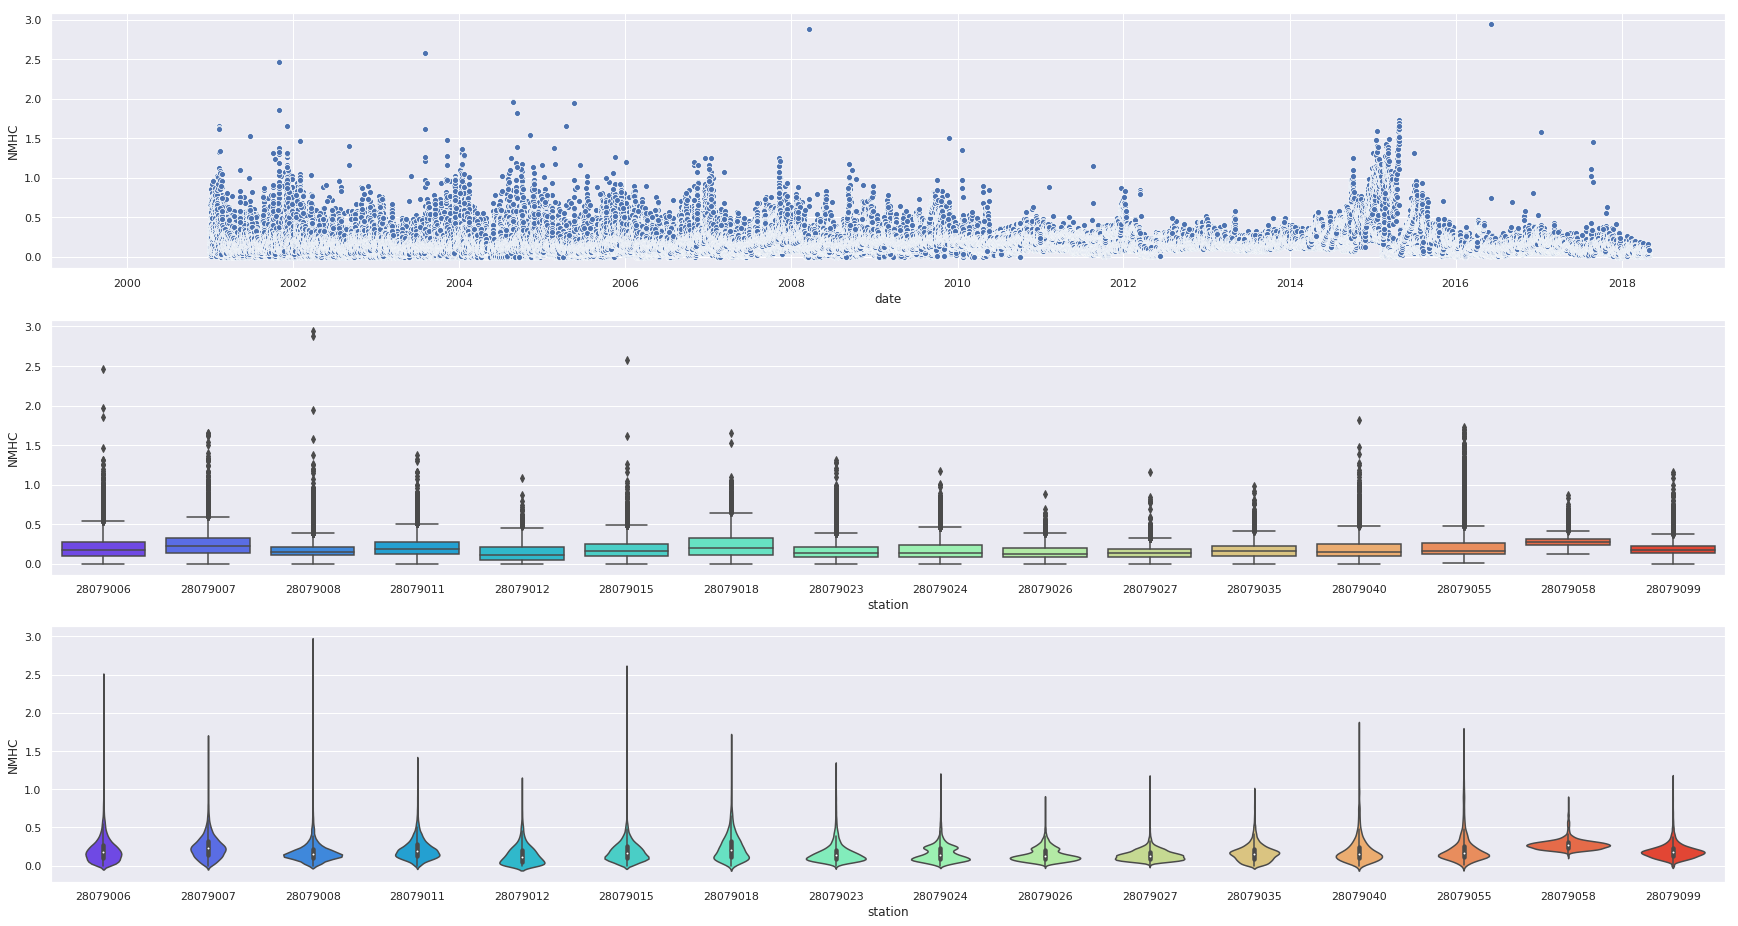

In [15]:
f = plt.figure(figsize=(30,16))
ax = f.add_subplot(3,1,1)
sns.scatterplot(x='date', y='NMHC', data=df_nmhc_8h, ax=ax)
ax = f.add_subplot(3,1,2)
palette = sns.color_palette("rainbow", 16)
sns.boxplot(x='station', y='NMHC', data=df_nmhc_8h, palette=palette, ax=ax)
ax = f.add_subplot(3,1,3)
palette = sns.color_palette("rainbow", 16)
sns.violinplot(x='station', y='NMHC', data=df_nmhc_8h, palette=palette)


In [16]:
df_nmhc_year = df_nmhc.dropna(axis=0).resample('8H').mean()
df_nmhc_year['year'] = df_nmhc_year.index.year
df_nmhc_year.reset_index(inplace=True)

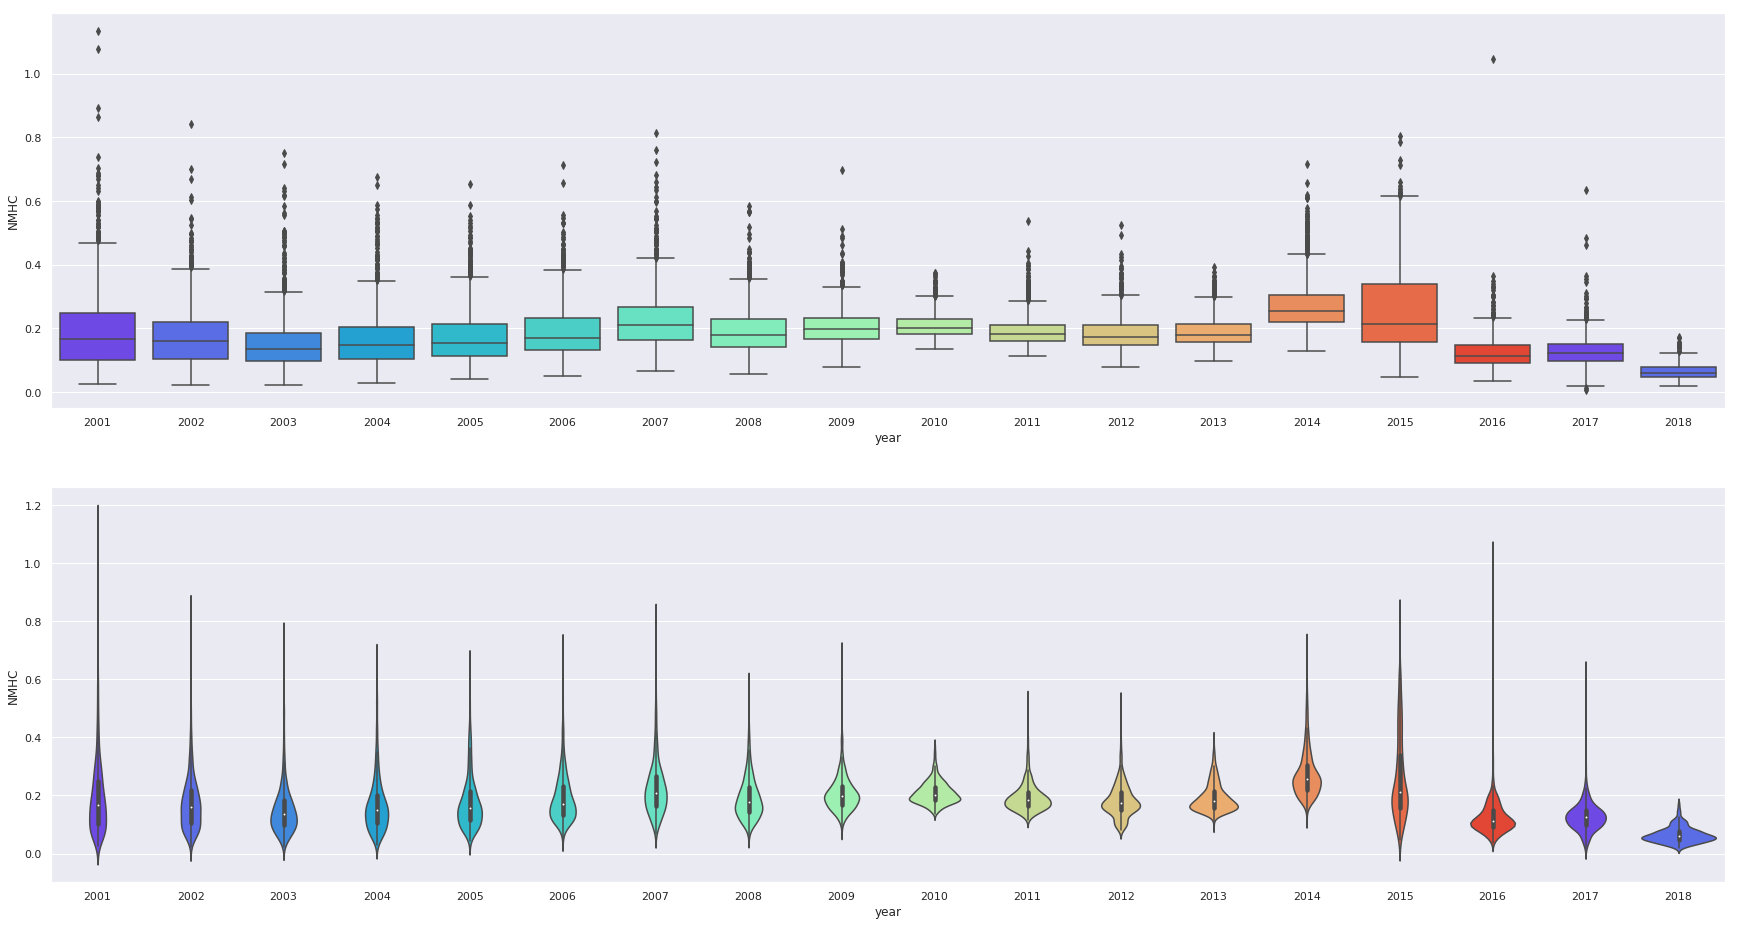

In [17]:
f = plt.figure(figsize=(30,16))
ax = f.add_subplot(2,1,1)
palette = sns.color_palette("rainbow", 16)
sns.boxplot(x='year', y='NMHC', data=df_nmhc_year, palette=palette, ax=ax)
ax = f.add_subplot(2,1,2)
palette = sns.color_palette("rainbow", 16)
sns.violinplot(x='year', y='NMHC', data=df_nmhc_year, palette=palette)

In [18]:
nan_columns = ['CO']

In [19]:
def random_imputation(df, feature):

    number_missing = df[feature].isnull().sum()
    observed_values = df.loc[df[feature].notnull(), feature]
    df.loc[df[feature].isnull(), feature + '_imp'] = np.random.choice(observed_values, number_missing, replace = True)
    
    return df

In [20]:
co_mean = measures['CO'].groupby('date').mean()

In [21]:
type(co_mean)

pandas.core.series.Series

In [22]:
df_mean = pd.DataFrame(data=co_mean, columns=['CO'])

In [23]:
# group data by different time periods
df_gr_D = df_mean.groupby(pd.Grouper(freq='D')).transform(np.mean).resample('D').mean()
df_gr_M = df_gr_D.groupby(pd.Grouper(freq='M')).transform(np.mean).resample('M').mean()

In [24]:
# prepare final dataset
df_detailed = df_gr_D.copy()
df_detailed['year'] = df_detailed.index.year
df_detailed['month'] = df_detailed.index.month
df_detailed['day'] = df_detailed.index.day
df_detailed.head()

,CO,year,month,day
date,,,,
2001-01-01,0.998400,2001,1,1
2001-01-02,0.709884,2001,1,2
2001-01-03,0.871186,2001,1,3
2001-01-04,0.848846,2001,1,4
2001-01-05,1.197067,2001,1,5


In [25]:
# finding max and min values per each month
max_vals_df = pd.DataFrame(columns=['year', 'month', 'volume'])
MIN_YEAR = min(df_detailed['year'])
MAX_YEAR = max(df_detailed['year'])
for i in range(MIN_YEAR, MAX_YEAR+1):
    max_val = max(df_detailed['CO'][df_detailed['year'] == i])
    if max_val > 0.0:
        month = df_detailed[(df_detailed['CO'] == max_val) & (df_detailed['year'] == i)]['month'].values[0]
        to_add = pd.DataFrame([[i, month, max_val]], columns=['year', 'month', 'volume'])
        max_vals_df = max_vals_df.append(to_add)

min_vals_df = pd.DataFrame(columns=['year', 'month', 'volume'])
for i in range(MIN_YEAR, MAX_YEAR+1):
    min_val = min(df_detailed['CO'][df_detailed['year'] == i])
    if min_val > 0.0:
        month = df_detailed[(df_detailed['CO'] == min_val) & (df_detailed['year'] == i)]['month'].values[0]
        to_add = pd.DataFrame([[i, month, min_val]], columns=['year', 'month', 'volume'])
        min_vals_df = min_vals_df.append(to_add)

In [26]:
max_vals_df['date'] = pd.to_datetime(max_vals_df.year.astype('str')+"-"+max_vals_df.month.astype('str'), format="%Y-%m")
max_vals_df = max_vals_df.set_index('date', drop=True)
max_vals_df.drop(['year', 'month'], axis=1, inplace=True)
max_vals_df

,volume
date,
2001-12-01,3.469549
2002-01-01,2.093117
2003-12-01,2.510978
2004-12-01,1.912863
2005-01-01,1.809360
2006-01-01,1.614670
2007-01-01,1.593207
2008-12-01,1.153714
2009-12-01,1.008407


In [27]:
min_vals_df['date'] = pd.to_datetime(min_vals_df.year.astype('str')+"-"+min_vals_df.month.astype('str'), format="%Y-%m")
min_vals_df = min_vals_df.set_index('date', drop=True)
min_vals_df.drop(['year', 'month'], axis=1, inplace=True)
min_vals_df

,volume
date,
2001-07-01,0.303715
2002-08-01,0.272667
2003-07-01,0.275304
2004-08-01,0.214667
2005-08-01,0.245984
2006-06-01,0.277115
2007-08-01,0.190677
2008-07-01,0.195226
2009-08-01,0.187083


In [28]:
# really useful function
def zero_to_nan(values):
    """Replace every 0 with 'nan' and return a copy."""
    return [float('nan') if x == 0 else x for x in values]


df_detailed['CO'] = zero_to_nan(df_detailed['CO'])

Text(0, 0.5, 'MAX CO pollution, mg/m3')

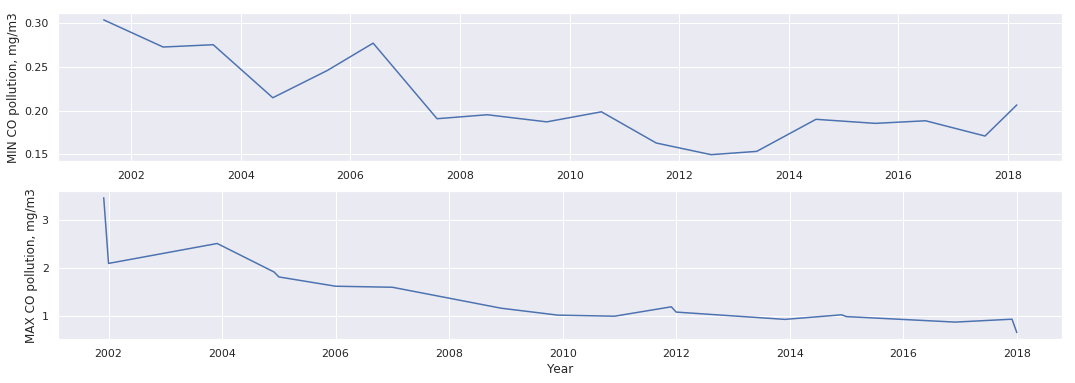

In [29]:
# plot 1 - difference between max and min values through time
f = plt.figure(figsize=(18,6))
ax = f.add_subplot(2,1,1)
sns.lineplot(data = min_vals_df.reset_index(), x='date', y='volume')
plt.xlabel('')
plt.ylabel('MIN CO pollution, mg/m3')
ax = f.add_subplot(2,1,2)
sns.lineplot(data = max_vals_df.reset_index(), x='date', y='volume')
plt.xlabel('Year')
plt.ylabel('MAX CO pollution, mg/m3')

Text(0.5, 1.0, 'CO pollution in Madrid 2001-2018')

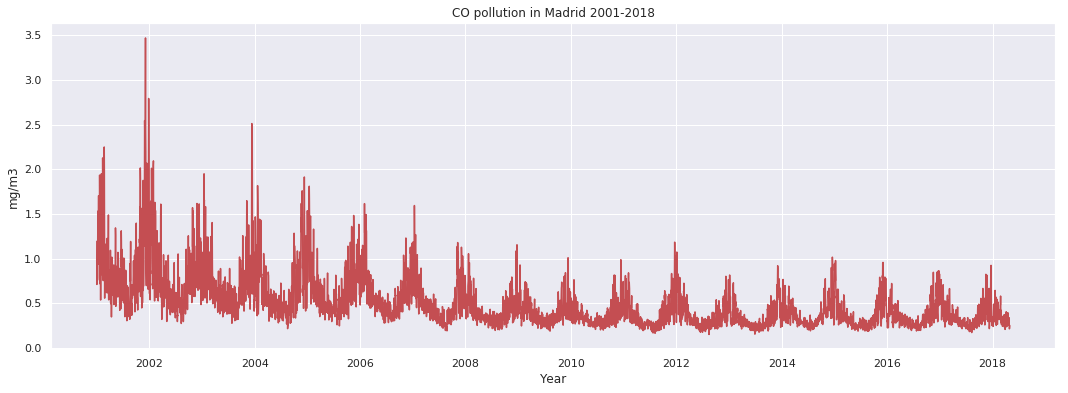

In [30]:
# plot 2 - changes in air pollution through years
years = []
for i in range(MIN_YEAR, MAX_YEAR+1, 2):
    years.append(i)

f = plt.figure(figsize=(18,6))
plt.plot(df_detailed.index, df_detailed['CO'], c='r')
plt.xlabel('Year')
plt.ylabel('mg/m3')
plt.title('CO pollution in Madrid 2001-2018')